# Teach Your Laptop to Trade Stock Options.
# Notebook 3: Train Machine Learners.
What could possibly go wrong?

6/10/2020

Internal notes - This is the live branch from OptionsTrainLearners_D1.ipynb. Develop this one, not _D1.

Added XGBoost classifier, but does not work.

## Purpose of this Notebook - Train Learners to trade stock options.
This notebook is the second in a series of notebooks that illustrate how to train a Machine learner to trade stock options, successfully, we hope. This notebook demonstrates how to train several Learners and compare them to choose the best one for your specific project. This notebook uses a data set of stock option trades for ExxonMobil (XOM) from 2017-2018 to illustrate many aspects of Machine Learning with the python SKLearn library. All the trades are short covered calls. 

What You Need: Basic knowledge of Python, pandas, numpy, dataframes, and statistics. 

What You Don't Need: Knowledge of stock options, scipy, sklearn, or Machine Learning. This project is self-contained and you will learn as you go.

You will Learn:

- How to display features for visual evaluation of feature quality.
- How to set up several Learners for comparison on your feature set.
- How to capture performance data and execution time data for comparison.
- How to display comparison data for visual inspection.


## 1. Explore the Feature Set.

Load the csv file training_features.csv into a dataframe. 

Although you do not need any konwledge of stock options, or even finance, to use this notebook, a little information may make it more interesting.

Column Name Abbreviations
- STO - 'Sell to Open.' A trader may sell or buy a put or call contract to open a trade.
- ARR - 'Annual Return Rate.' The equivalent rate of return on the trade, if it expires, on an annual basis.
- strike_delta% - The difference between the stock price and the option strike price (the delta) as a % of stock price.
- days long - The number of days from the trade date to the expiry date.

Evaluation Questions: 
- Do think these features are sufficient to predict the profitability of this type of option trade? Why, why not?
- What other features would you add to this feature set?
- How will you evaluate feature quality and contribbution to the results?

Code Questions:
- How many features are in this feature set?
- What is the data type of each feature?
- What are the statistics of each feature? Get the min, max, mean, and standard deviation of each.


In [1]:
import pandas as pd
import numpy as np
training_features = pd.DataFrame()
training_features = pd.read_csv('training_features_wlabel.csv', index_col = False)
print(training_features.head(5))
print(training_features.columns.to_list())

   Unnamed: 0  stock_price_at_STO_offer  STO_strike  STO_days_long  \
0           0                     81.82        80.0           11.0   
1           1                     81.81        80.0           11.0   
2           2                     81.82        80.5           11.0   
3           3                     81.81        80.5           11.0   
4           4                     82.10        80.5           11.0   

   STO_offer_ARR  stock_price_at_open  STO_ask_fee%  STO_offer_strike_delta%  \
0       0.786760                82.10      0.023711                -0.022244   
1       0.784828                82.10      0.023652                -0.022124   
2       0.618458                82.10      0.018638                -0.016133   
3       0.608394                82.10      0.018335                -0.016013   
4       0.701224                82.14      0.021133                -0.019488   

   Closed_xtn_Profit$  Closed_xtn_Profit%  ...        MFI     MACD  \
0              -610.0       

## 2. Visualize the Feature Set

With Matplotlib, compare the features when grouped by proitable trades ('winners' with label = 1) vs. unprofitable trades ('losers' with label = 0). 

(5577, 29)
setting up bins.


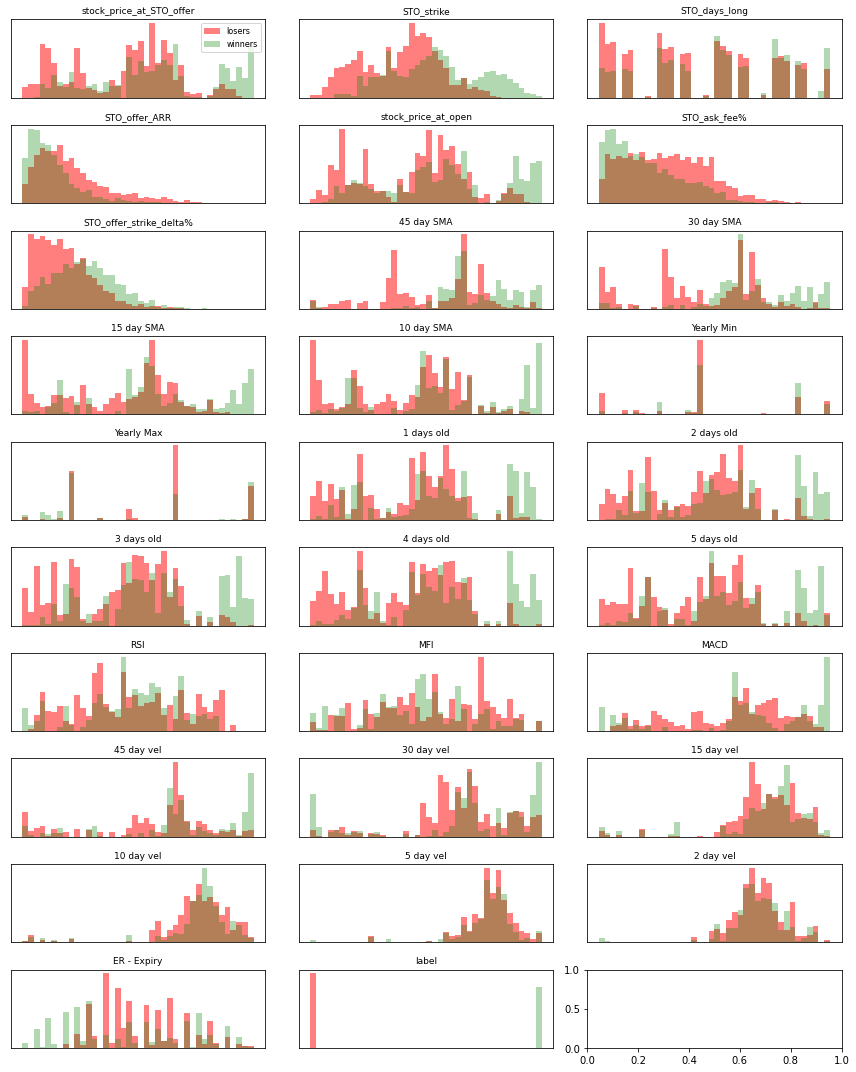

In [2]:
import matplotlib
import matplotlib.pyplot as plt

opt_sample = pd.read_csv('opt_sample.csv', index_col = 0)
print(opt_sample.shape)
#print(opt_sample.head(5))
fig,axes =plt.subplots(10,3, figsize=(12, 15)) # 3 columns each containing 9 figures, total 27 features
winners = opt_sample[opt_sample['label']==1]    # define winners
losers  = opt_sample[opt_sample['label']==0]    # define losers

winners = winners.to_numpy()
losers  = losers.to_numpy()
opt_np = opt_sample.to_numpy()

ax=axes.ravel()# flat axes with numpy ravel

print('setting up bins.') 
for i in range(len(opt_sample.columns.values)):
  _,bins=np.histogram(opt_np[:,i],bins=40)
  
  ax[i].hist(losers[:,i],bins=bins,color='r',alpha=.5)# red color for malignant class
  ax[i].hist(winners[:,i],bins=bins,color='g',alpha=0.3)# alpha is           for transparency in the overlapped region
  ax[i].set_title(opt_sample.columns.values[i],fontsize=9)
  ax[i].axes.get_xaxis().set_visible(False) # the x-axis co-ordinates are not so useful, as we just want to look how well separated the histograms are
  ax[i].set_yticks(())
ax[0].legend(['losers','winners'],loc='best',fontsize=8)
plt.tight_layout()# let's make good plots
plt.show()


Each chart above shows a collection of green bars and red bars for a single feature. 

Evaluation Questions:
 - What is the meaning of the green bars and red bars?
 - By looking at the charts, can you identify which features contain more information to train the Learners? How? Why?
 - Which chart shows perfect separation between the red and green bars. Why?
 - Can we use this feature to train the Learners? Why, why not?
 - In your opinion, can we train the Learners effectively with this set of features? Why, why not? 
 
 Code Questions:
 - Develop a single metric that defines the relationship between red and greed data points for each feature.
 - Compare your metric to the charts. Does your metric provide additional insight? Why, why not.
 - Calculate the correlation matrix of all the features. Hint, this is a single line of code with a dataframe.
 - Rank the features with the highest correlation, then plot the correlation as a series of charts. Any benefit?
 - Rank the correlation of each feature with the label, then plot. Any additional benefit?
 
The correlation analysis is one method to perform feature reduction or elimination, which is a key component in feature development. The next notebook in this series shows several techniques to do feature elimination.

## 3. Write the Function to Test Different Classifiers.

Review the function to train, test, and measure different Learners. Review the online documentation for the SKLearn library and read about each of these Learners.

Evaluation Questions:
 - What is a regressor? a classifier? Which should we use for this project as set up? Why?
 - How would we change the setup to use the other type? Which would be better? Why?
 - Describe each Learner in your own words. Which ones do you think will work best for this project? Why?
 - RandomForest and AdaBoost are called "ensemble learners." Why?
 
Code Questions:
 - When you execute the code block below, what output do you expect to see? Why? This is a trick question.
 - How will you add another Learner to the evaluation set? OK, then do it.

In [7]:
# Import ML Libraries from SKLearn.

from sklearn import svm
from sklearn import metrics
from sklearn.decomposition     import PCA
from sklearn.preprocessing     import StandardScaler
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.neural_network    import MLPClassifier
from sklearn.ensemble          import RandomForestClassifier, AdaBoostClassifier
from sklearn.datasets          import make_classification
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.neural_network    import MLPClassifier
from sklearn.naive_bayes       import GaussianNB 
from sklearn.feature_selection import SelectKBest
import xgboost
from xgboost                   import XGBClassifier
from sklearn.feature_selection import chi2
from sklearn.metrics           import accuracy_score

import time
import random

def RunLearners(Xr_train, Xr_test, yr_train, yr_test, all_run_stats, run_ID):
   print() 
   print('Please be patient. Some of these Learners are pretty slow learners.')
   print('If you get impatient, put in a print statement to show progress, or just use one already in place.')
   print()
    
   this_run_stats = pd.DataFrame()
   
   learners = {#'RandomForest_d6'  : RandomForestClassifier(max_depth=3, random_state=97),
               'RandomForest_d12' : RandomForestClassifier(max_depth=12, random_state=97),
               'KNNeighbors_2'    : KNeighborsClassifier(n_neighbors=3),
               #'KNNeighbors_8'    : KNeighborsClassifier(n_neighbors=8),
               'MLPerceptron'     : MLPClassifier(alpha=1, max_iter=1000),
               'SVC linear'       : svm.SVC(kernel = 'linear'),
               'SVC poly'         : svm.SVC(kernel = 'poly'),
               'GaussianNB'       : GaussianNB(),
               'AdaBoost'         : AdaBoostClassifier(),
               'XGBoost'          : XGBClassifier()
               #'SVC sigmoid'      : svm.SVC(kernel = 'sigmoid')
               }

   learner_types = learners.keys()
   for learner in learner_types:
      clf = learners[learner]
      start_time = time.time()  
      clf.fit(Xr_train, yr_train)
      end_time = time.time()
      train_time = end_time - start_time
      start_time = time.time()  
      yr_pred = clf.predict(X_test)
      end_time = time.time()
      predict_time = end_time - start_time
        
      #print()
      #print('for learner ', learner)
      #print(learner, ' accuracy      = ', metrics.accuracy_score(yr_test, yr_pred))
      #print(learner, ' avg. precison = ', metrics.average_precision_score(yr_test, yr_pred))

      this_run_stats.loc[learner, 'Accuracy']     = metrics.accuracy_score(yr_test, yr_pred)
      this_run_stats.loc[learner, 'Precision']    = metrics.average_precision_score(yr_test, yr_pred)
      this_run_stats.loc[learner, 'Train time']   = train_time
      this_run_stats.loc[learner, 'Predict time'] = predict_time

   this_run_stats['run_ID'] = run_ID
   all_run_stats = all_run_stats.append(this_run_stats)
   return all_run_stats
   print('all_run_stats = ')
   print(all_run_stats) 

print()
print('No output yet. Call this function with a set of train and test features.')
print('Then run the code block below to prepare a set of train and test data, then call the function RunLearners')
print('to execute each of the Learners and collect performance metrics.')



No output yet. Call this function with a set of train and test features.
Then run the code block below to prepare a set of train and test data, then call the function RunLearners
to execute each of the Learners and collect performance metrics.


## 4. Investigate the train and test data sets.
Run the code block below, then consider these questions.

Evaluation Questions:
- Explain the differences between X_train, y_train, X_test, and y_test. 
- What are the dimensions of each?
- What is the purpose of each?
- What is the difference between a numpy array and a dataframe? Which works with a Learner?
- How does the code modify X_train? Why?

In [8]:
# Prepare the test and train data sets.

X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test  = pd.DataFrame()
y_test  = pd.DataFrame()

learner_stats = pd.DataFrame()

X_train  = pd.read_csv('opt_sample.csv', index_col = 0)

#print(X_train.head(10))
y_train = X_train[['label']].to_numpy()
y_train = y_train.ravel()
print('y_train shape = ', y_train.shape)
X_train.drop(labels = 'label', axis = 'columns', inplace = True)
print('X_train shape = ', X_train.shape)

X_test = pd.read_csv('opt_test.csv', index_col = 0)
y_test = X_test[['label']].to_numpy()
X_test.drop(labels = 'label', axis = 'columns', inplace = True)

y_train = np.ravel(y_train)
y_test  = np.ravel(y_test)
#print('y_train = ', y_train)
#print('y_test = ', y_test)

run_ID = 'Initial'
learner_stats = RunLearners(X_train, X_test, y_train, y_test, learner_stats, run_ID)
print(learner_stats)
learner_stats.to_csv('learner_stats.csv')

y_train shape =  (5577,)
X_train shape =  (5577, 28)

Please be patient. Some of these Learners are pretty slow learners.
If you get impatient, put in a print statement to show progress, or just use one already in place.

                  Accuracy  Precision  Train time  Predict time   run_ID
RandomForest_d12  0.965708   0.946245    1.282262      0.047989  Initial
KNNeighbors_2     0.955199   0.921311    0.063982      0.132269  Initial
MLPerceptron      0.837942   0.749951    5.337660      0.008000  Initial
SVC linear        0.846792   0.772990   24.851030      0.147959  Initial
SVC poly          0.834624   0.759835    1.266584      0.271928  Initial
GaussianNB        0.694690   0.595571    0.007998      0.003999  Initial
AdaBoost          0.892699   0.834792    0.805011      0.046867  Initial
XGBoost           0.991704   0.985255    0.997176      0.011997  Initial


## 5. Plot and Compare Performance of the Learners.

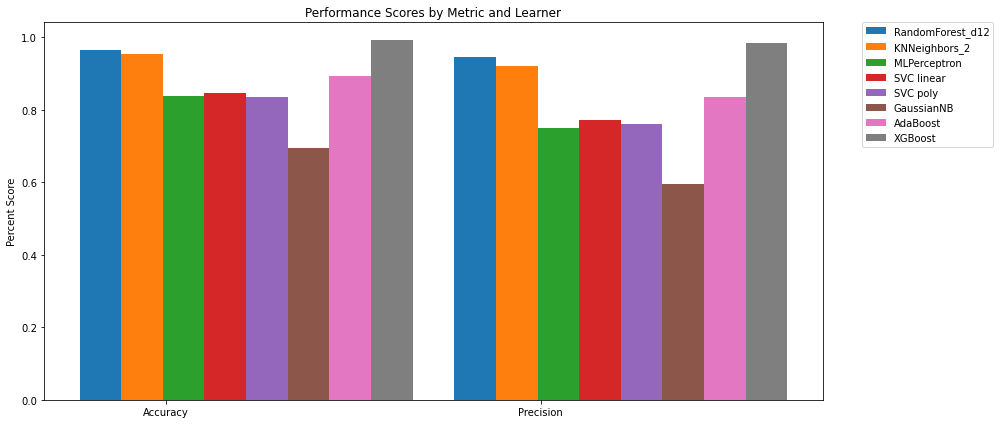

In [9]:
#Print and compare Learner performance in grouped bar chart format

def PlotGroupedBarChart(group_list, agent_list, scores):
   
    agent_scores = []
    rects = []
    labels = group_list # bar chart groups
    num_labels = len(labels) + 1

    num_agents = len(agent_list) + 1
    num_bars = num_labels * num_agents
    bar_width = 3 / num_bars
    width = .35
    
    plt.rcParams['figure.figsize'] = [14,6]

    x = np.arange(len(labels))  # the label locations

    fig, ax = plt.subplots()
    num_bars = len(agent_list)
    bar_posn = 0
    for agent in agent_list:
        agent_scores = [scores.loc[agent, labels[0]], scores.loc[agent, labels[1]]]
        rects.append(ax.bar(x - width/2  + bar_width * bar_posn, agent_scores, bar_width, label=agent))
        bar_posn += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percent Score')
    ax.set_title('Performance Scores by Metric and Learner')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    #plt.legend(loc = 'lower right')
    fig.tight_layout()
    plt.show()
    
#Run the plot function to compare performance of the Learners.

metrics = ['Accuracy', 'Precision']
agents  = learner_stats.index.tolist()

PlotGroupedBarChart(metrics, agents, learner_stats)

Refer to the performance chart above to answer these questions:

Evaluation Questions:
- What is the difference between accuracy and precision? What other performance metrics might be useful here?
- Which Learner performed best on both metrics?
- Comparing RandomForest Learners, what do the suffixes mean?
- Whic RandomForest did better? Why?
- What problems would you expect to see if we continued increasing the d parameter?
- How can you find the best value for the d parameter?
- Do the same comparison and analysis for the KNNeighbors numeric suffix.
- Why did RandomForest and KNNeighbors perform so much better than MLPerceptron and SVC?
- Based on the performance parameters, would you consider this exercise to be linear, nonlinear, or other? Why, why not?

Code Questions:
- Change the parameter suffixes and corresponding parameters for KNNeighbor and RandomForest. Explain the results.
- Test another type of classifier. Predict the results for that classifier, then run it and compare to your prediction. 
- Change the parameters for SVC and MLP. Can you improve their performance with different parameters?
- Change the y axis of the plot to expand the performance differences of the Learners. Is that better, or just deceptive?


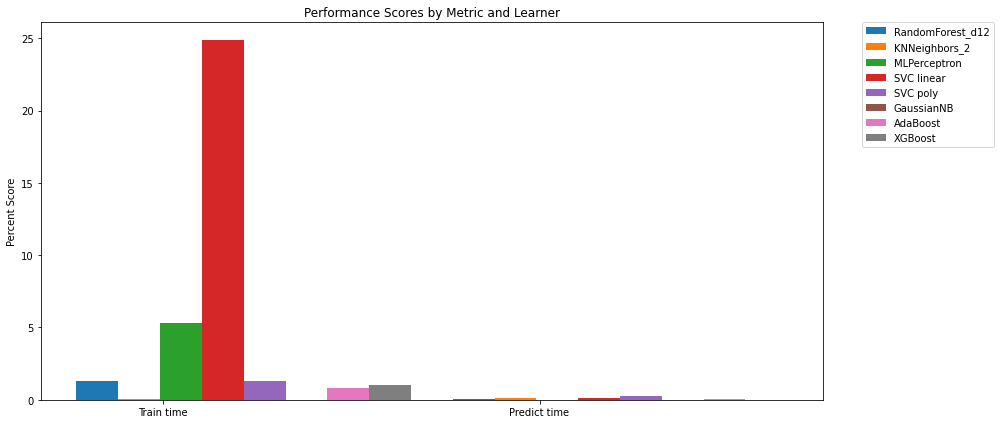

In [10]:
#Run the plot function to compare execution time of the Learners.

#Plot execution time metrics
exec_times = ['Train time', 'Predict time']

PlotGroupedBarChart(exec_times, agents, learner_stats)



Refer to the chart above to answer these questions about execution times.

Evaluation Questions:
- Why does SVC Linear take so long to train?
- Why does KNNeighbors train so quickly?
- Why does RandomForest train time increase as the d parameter increases?
- Why is prediction time so much faster than train time for all Learners?
- Which is more important - train time or prediction time? Why? What circumstances?
- What circumstances or requirements might change the relative importance of train time vs. prediciton time?
- Given the execution times above, can you predict how train time will change as the training data set increases? Why?

Code Questions:
- In the chart, execution times are not well displayed. Change the chart to improve their display.
- Which data sets are used for training?
- Make those data sets 50% smaller, then 90% smaller, then rerun the Learners and plot the results.
- How do the results change with the smaller data sets? Why?

## Congratulations, You trained and compared several Learners.

Congratulations! You just trained several Learners to pick winning stock option trades. Now, you are almost ready to make a fortune in the stock market. But, first... consider these questions:

- How can you improve the feature set? 
- Which Learner(s) would you choose? Why?
- How can you gain more confidence in your trader?
- What is your goal? Single profitable trades, or a portfolio of trades? What's the difference?

Tune into the next exciting notebook to explore questions of maximizing portfolio results for options trading. 

Wishing you only profitable trades and good learning,

Richard Barrett

richard at rbshomes dot com.
925.858.9017

P.S. I want to hear about your adventures in Machine Learning, your questions and comments about stock option trading, and especially your specific applications for machine learning. Just shoot me an email, a text, or even call.
